In [79]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import sys
from pathlib import Path

# Add project root to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

from modules.simulation import UniverseSimulator
import configparser

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [80]:
cfg_ini_new['parameters']['sigma_Mwl_gal']

'0.0'

In [81]:
import configparser
default_config_capish = configparser.ConfigParser()
default_config_capish.read('../config/capish_flagship.ini')

['../config/capish_flagship.ini']

In [98]:
default_config_capish.keys()

KeysView(<configparser.ConfigParser object at 0x7f9330a63130>)

In [93]:
import configparser
default_config_capish = configparser.ConfigParser()
default_config_capish.read('../config/capish_flagship.ini')
default_config_capish['parameters']['sigma_Mwl_gal'] = '0.1'
default_config_capish['parameters']['sigma_Mwl_int'] = '0.05'
default_config_capish['parameters']['log10M_min'] = '14.5'
default_config_capish['parameters']['alpha_lambda'] = '3.5'
default_config_capish['parameters']['beta_lambda'] = '1.72'
default_config_capish['parameters']['gamma_lambda'] = '0.0'
default_config_capish['cluster_catalogue']['gaussian_lensing_variable'] = 'log10Mwl'
default_config_capish['cluster_catalogue.mass_observable_relation']['which_relation'] = 'power_law'
default_config_capish['cluster_catalogue']['theory_sigma_Mwl_gal'] = 'True'
default_config_capish['summary_statistics']['use_stacked_sigma_Mwl_gal'] = 'True'
default_config_capish['summary_statistics']['use_stacked_sigma_Mwl_int'] = 'True'
sim = UniverseSimulator(default_config_path = None , default_config = default_config_capish, 
                        variable_params_names = ['Omega_m','sigma8'])

Loading /pbs/throng/lsst/users/cpayerne/capish/modules/cluster/model_log10mWL_Rmin1.0_Rmax5.0_ngal25.0_ShapeNoise0.3_M200matter_cMDuffy08.pkl
Loading /pbs/throng/lsst/users/cpayerne/capish/modules/cluster/model_log10mWL_Rmin1.0_Rmax5.0_ngal25.0_ShapeNoise0.3_M200matter_cMDuffy08.pkl


In [94]:
N, log10M = sim.run_simulation([0.319, 0.81])

0.0


In [95]:
N.shape

(5, 4)

Text(0, 0.5, 'log10M_capish')

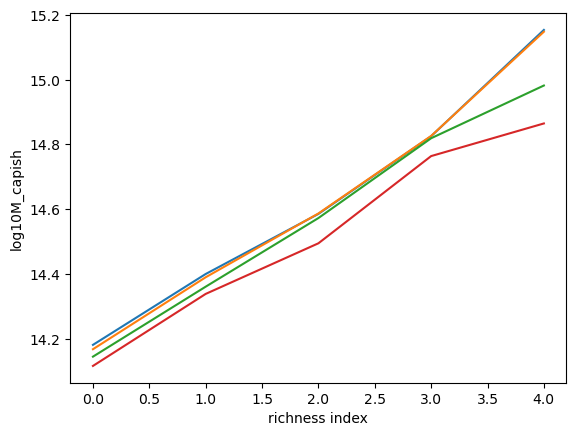

In [96]:
plt.plot(log10M)
plt.xlabel('richness index')
plt.ylabel('log10M_capish')

In [55]:
def mean_obs_relation_DES( log10M, z, params_observable_mean):
        alpha_lambda, beta_lambda, gamma_lambda = params_observable_mean
        # Ensure all are float
        alpha_lambda = float(alpha_lambda)
        beta_lambda = float(beta_lambda)
        gamma_lambda = float(gamma_lambda)

        # Ensure z and log10M are numeric arrays
        z = np.array(z, dtype=float)
        log10M = np.array(log10M, dtype=float)

        # Convert log10M to M, subtract M_min, then back to log10
        M = 10 ** log10M
        M_term = M - 10 ** 11.13

        # Ensure M_term is positive to avoid log of negative numbers
        M_term = np.maximum(M_term, 1e10)  # Set minimum value to avoid log issues

        # Note: This returns ln(lambda), which gets exponentiated later to get lambda
        ln_lambda = np.log(10) * (alpha_lambda + beta_lambda * np.log10(M_term) + gamma_lambda * np.log10(1 + z))
        return ln_lambda

def mean_obs_relation_power_law(log10M, z, params_observable_mean):
    alpha_lambda, beta_lambda, gamma_lambda, log10M_min, z0 = params_observable_mean
    # Ensure all are float
    alpha_lambda = float(alpha_lambda)
    beta_lambda = float(beta_lambda)
    gamma_lambda = float(gamma_lambda)

    z = np.array(z, dtype=float)
    log10M = np.array(log10M, dtype=float)
    
    ln_lambda = alpha_lambda + beta_lambda * (log10M - log10M_min) + gamma_lambda * np.log((1 + z)/(1 + z0))
    return ln_lambda

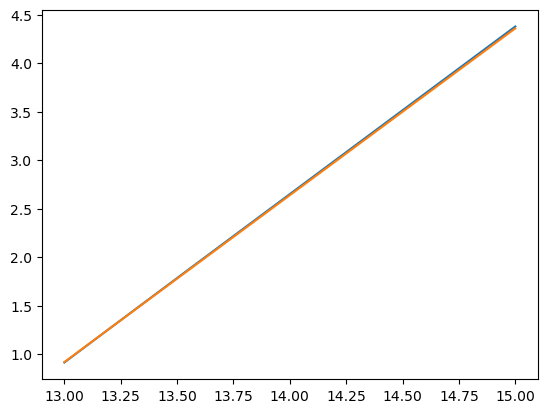

In [56]:
log10m = np.linspace(13, 15, 100)
z=0.5
alpha_lambda = -9.348
beta_lambda = 0.75
gamma_lambda = 0.0
sigma_lambda = 0.3
y1 = mean_obs_relation_DES( log10m, z, [-9.348, 0.75, 0])
plt.plot(log10m,y1)
y2= mean_obs_relation_power_law( log10m, z, [3.5, 1.72, 0, 14.5, 0.5 ])
plt.plot(log10m,y2)

In [57]:
sys.path.append('/pbs/throng/lsst/users/cpayerne/capish/')
from modules.cluster import cluster_catalogue

In [58]:
cl = cluster_catalogue.ClusterCatalogue(default_config_capish)

In [59]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Define colormap based on log10m range
norm = mcolors.Normalize(vmin=np.min(cl.log10m_grid[cl.log10m_grid > 13.5]), vmax=np.max(cl.log10m_grid[cl.log10m_grid > 13.5]))
cmap = cm.hsv  # you can change to 'plasma', 'cividis', etc.
sm = cm.ScalarMappable(norm=norm, cmap=cmap)

plt.figure(figsize=(5,4))

# Loop through each mass
for i, log10m in enumerate(cl.log10m_grid):
    if log10m < 13.5: continue
    color = sm.to_rgba(log10m)
    plt.plot(
        cl.z_grid,
        cl.sigma_log10M[i, :], '--',
        color=color,
        lw=1
    )

    plt.plot(
        cl.z_grid,
        np.sqrt(cl.sigma_log10M[i, :]**2 + 0.05**2),
        color=color,
        lw=1, ls='-', 
    )
plt.plot(
        cl.z_grid,
        np.sqrt(0.05**2) * np.ones(len(cl.z_grid)),
        color='k',
        lw=2, ls=':',  label = r'$\sigma_{\rm WLint}$'
    )
plt.plot([], [], '--k', label = r'$\sigma_{\rm WLgal}$')
plt.plot([], [], '-k', label = r'$\sigma_{\rm WL}$')
# Add colorbar and labels
cbar = plt.colorbar(sm)
cbar.set_label(r'$\log_{10}(M / M_\odot)$', fontsize=14)
plt.legend(ncols=1, frameon=True, framealpha=1, loc='upper left', fontsize=10)
#plt.yscale('log')
plt.ylim(-0., 0.6)
plt.xlabel('Redshift', fontsize=14)
plt.ylabel(r'$\sigma(\log_{10}M)$', fontsize=16)
#plt.hlines(0.2, 0.2, 1.2, color='k', ls='--')
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.xlim(0.2, 1.2)
plt.savefig(f'sigmaWL.png', dpi = 300, bbox_inches='tight',)

TypeError: '>' not supported between instances of 'NoneType' and 'float'

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Define colormap based on log10m range
norm = mcolors.Normalize(vmin=np.min(cl.z_grid), vmax=np.max(cl.z_grid))
cmap = cm.rainbow # you can change to 'plasma', 'cividis', etc.
sm = cm.ScalarMappable(norm=norm, cmap=cmap)

plt.figure(figsize=(5,3))

# Loop through each mass
for i, z in enumerate(cl.z_grid):

    color = sm.to_rgba(z)
    plt.plot(
        cl.log10m_grid,
        cl.sigma_log10M[:,i], '-',
        color=color,
        lw=1
    )


  


# Add colorbar and labels
cbar = plt.colorbar(sm)
cbar.set_label(r'redshift', fontsize=14)
#plt.legend(ncols=1, frameon=True, framealpha=1, loc='upper left', fontsize=14)
#plt.yscale('log')
plt.ylim(-0., 0.6)
plt.xlim(13.5, 16)
plt.xlabel(r'$\log_{10}(M / M_\odot)$', fontsize=14)
plt.ylabel(r'$\sigma_{\rm WL}$', fontsize=16)
#plt.hlines(0.2, 0.2, 1.2, color='k', ls='--')
plt.grid(True, alpha=0.4)
plt.tight_layout()
#plt.xlim(0.2, 1.2)
plt.savefig(f'sigmaWL.png', dpi = 300, bbox_inches='tight',)